## **ICR - Identifying Age-Related Conditions Dataset** 

Baseline model: The person has none of the three conditions

**Questions I have for the group:**

4. Epsilon is a date: 
    - Do we want to leave only the year?
    - Could leave as a numerical (**epoch time**)
    - correlation with 1/0 over time
    - Try with/ without
    - split time-wise, not randomly 
    - Split into smaller portions, but maybe not a year
7. Greeks: 
- EDA with time 
- Don't include in model because in Kaggle they won't test it (test data doesn't have those)
- Include Epsilon, because TEST was collected post TRAIN
- Trends in time with 0 and 1 and weigh the ones closer to test heavier


**Ask Cornelia:**
- Is there any advantage to standardizing data for random trees?
- Can you explain the difference between the outputs of tSNE and PCA? 
- If we weight the classes AND do k-folds cross validation to address class imbalance, is accuracy still a poor evaluation metric? 


**To-dos:**
- Turn the "dummies" into a function 
- Check whether the random trees model includes bagging (read documentation)
- Imputing: when to use mean imputation vs. regression imputation
- Set seed so that split is always the same
- Get aucrc to work. Maybe try this:  https://towardsdatascience.com/tensorflow-decision-forests-a-comprehensive-introduction-3b6056a6d6b0


In [3]:
# Akabane et al. test/train split
akabane_train = (6564/8792)*100
akabane_test = (2228/8792)*100

print(f"Akabane et al train: {akabane_train:.0f}%, test: {akabane_test:.0f}%")
print("Alageel et al train: 80%, test: 20%")

Akabane et al train: 75%, test: 25%
Alageel et al train: 80%, test: 20%


#### ``Objectives``

#### ``Motivation``

#### ``Data``

### Step 1: Import libraries

---

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics


from sklearn.model_selection import KFold
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss



#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows



### Step 2: Define functions

---

In [5]:
#auprc for metrics
def auprc(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)

def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

### Step 3: Read data

---

In [6]:
#set working directory
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset_df = pd.read_csv('train.csv')
print("Full dataset shape is {}".format(dataset_df.shape)) 

Full dataset shape is (617, 58)


In [7]:
# data
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [8]:
# metadata
greeks_df = pd.read_csv('greeks.csv')
greeks_df.head()


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


### Step 4: Preprocess data

---

In [9]:
# merge greeks and dataset
all_vars = dataset_df.merge(greeks_df, left_on='Id', right_on='Id')
all_vars.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [10]:
# check column names. Drop Alpha and Id because its also the class , and Id irrelevant 
all_vars = all_vars.drop(['Alpha','Id'], axis=1)
all_vars.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Beta',
       'Gamma', 'Delta', 'Epsilon'],
      dtype='object')

In [12]:
# Check datatypes for each column
all_vars.dtypes

AB         float64
AF         float64
AH         float64
AM         float64
AR         float64
AX         float64
AY         float64
AZ         float64
BC         float64
BD         float64
BN         float64
BP         float64
BQ         float64
BR         float64
BZ         float64
CB         float64
CC         float64
CD         float64
CF         float64
CH         float64
CL         float64
CR         float64
CS         float64
CU         float64
CW         float64
DA         float64
DE         float64
DF         float64
DH         float64
DI         float64
DL         float64
DN         float64
DU         float64
DV         float64
DY         float64
EB         float64
EE         float64
EG         float64
EH         float64
EJ          object
EL         float64
EP         float64
EU         float64
FC         float64
FD         float64
FE         float64
FI         float64
FL         float64
FR         float64
FS         float64
GB         float64
GE         float64
GF         f

In [13]:
#Change Unknown to Nan in order to format dates
all_vars['Epsilon'] = all_vars['Epsilon'].replace('Unknown', np.nan)  # Replace 'Unknown' with NaN

#split the date into DD/MM/YYYY NOT -1 for missing 
all_vars['Epsilon'] = pd.to_datetime(all_vars['Epsilon'])  # Convert the column to datetime format
all_vars['Day'] = all_vars['Epsilon'].dt.day.fillna(-1).astype(int)
all_vars['Month'] = all_vars['Epsilon'].dt.month.fillna(-1).astype(int)
all_vars['Year'] = all_vars['Epsilon'].dt.year.fillna(-1).astype(int)


all_vars['Day']
all_vars['Month']
all_vars['Year']

0      2019
1        -1
2        -1
3        -1
4      2020
5      2019
6      2019
7      2019
8      2019
9      2020
10     2020
11     2019
12     2019
13     2019
14     2018
15     2019
16     2020
17     2020
18     2019
19     2019
20       -1
21     2020
22     2020
23       -1
24       -1
25     2020
26     2019
27       -1
28       -1
29     2020
30     2019
31     2020
32     2020
33     2020
34     2020
35       -1
36     2019
37       -1
38       -1
39     2020
40     2019
41     2019
42     2019
43     2019
44       -1
45     2019
46     2019
47     2019
48     2019
49     2019
50     2019
51     2020
52     2019
53     2019
54       -1
55     2020
56     2020
57     2020
58     2019
59     2020
60     2019
61     2019
62     2018
63     2020
64     2019
65     2019
66     2020
67       -1
68     2019
69       -1
70     2020
71     2019
72     2019
73       -1
74     2020
75     2019
76     2019
77     2020
78     2020
79     2019
80     2019
81     2020
82     2019
83  

In [ ]:
#check seasonal tendencies (in 1/0) to decide whether or not to include the date in our model 

In [14]:
all_vars.dtypes

AB                float64
AF                float64
AH                float64
AM                float64
AR                float64
AX                float64
AY                float64
AZ                float64
BC                float64
BD                float64
BN                float64
BP                float64
BQ                float64
BR                float64
BZ                float64
CB                float64
CC                float64
CD                float64
CF                float64
CH                float64
CL                float64
CR                float64
CS                float64
CU                float64
CW                float64
DA                float64
DE                float64
DF                float64
DH                float64
DI                float64
DL                float64
DN                float64
DU                float64
DV                float64
DY                float64
EB                float64
EE                float64
EG                float64
EH          

In [15]:
# dummies for categorical variables alpha, beta, gamma, ej
columns_to_dummy = ['Beta', 'Gamma', 'Delta','EJ']


# beta
beta_dummy = pd.get_dummies(
    all_vars['Beta'], prefix='Beta', dtype=int
)

# gamma
gamma_dummy = pd.get_dummies(
    all_vars['Gamma'], prefix='Gamma', dtype=int
)


# delta
delta_dummy = pd.get_dummies(
    all_vars['Delta'],prefix='Delta', dtype=int
)

# ej
ej_dummy = pd.get_dummies(
    all_vars['EJ'],prefix='EJ', dtype=int
)


# add to initial df
with_dummies_df = pd.concat(
    [all_vars,beta_dummy,gamma_dummy,ej_dummy],
    axis=1
)

with_dummies_df.dtypes

AB                float64
AF                float64
AH                float64
AM                float64
AR                float64
AX                float64
AY                float64
AZ                float64
BC                float64
BD                float64
BN                float64
BP                float64
BQ                float64
BR                float64
BZ                float64
CB                float64
CC                float64
CD                float64
CF                float64
CH                float64
CL                float64
CR                float64
CS                float64
CU                float64
CW                float64
DA                float64
DE                float64
DF                float64
DH                float64
DI                float64
DL                float64
DN                float64
DU                float64
DV                float64
DY                float64
EB                float64
EE                float64
EG                float64
EH          

In [16]:
#drop Beta, Gamma, Delta, Epsilon
all_vars = with_dummies_df.drop(['Beta','Gamma','Delta','Epsilon','EJ'], axis=1)
all_vars.columns


Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Day', 'Month',
       'Year', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'EJ_A', 'EJ_B'],
      dtype='object')

``split data into training and test``

In [17]:
# define outcome #
##################
y = all_vars['Class'].values
y

# define features #
###################
columns = [i for i in all_vars.columns if i not in ['Class']] 
X = all_vars[columns].values


# split #
#########
split = (0.8,0.2) #80% training and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# # rename columns
df_train.columns=['Class', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL',  'Day', 'Month',
       'Year', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'EJ_A', 'EJ_B']

In [18]:
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)

Shape X_train:  (493, 71) 
Shape X_test:  (124, 71) 
Shape y_train:  (493,) 
Shape y_test: (124,)


### Step 5: EDA

---


1. Columns: 1 Class column (0/1) and 71 features (with one-hot encoding for categorical variables)
2. Check data types: Features are float64, one-hot encoding are int, Label 'Class' is int64
3. Count number of nulls per feature: imputed with mean value 

BQ    49
CB     1
CC     2
EL    51
FC     1
FS     2

4. Check for duplicates: none
5. Summary statistics: The distributions of the features vary, so we would probably benefit from standarization. 
6. Histogram of variables: The labels show class imbalance, so we'll do k-fold cross-validation 


In [19]:
# Look at the dataset
df_train.dtypes
# df_train.head()
# df_train.shape[1]
# df_train.describe()

Class        int64
AB         float64
AF         float64
AH         float64
AM         float64
AR         float64
AX         float64
AY         float64
AZ         float64
BC         float64
BD         float64
BN         float64
BP         float64
BQ         float64
BR         float64
BZ         float64
CB         float64
CC         float64
CD         float64
CF         float64
CH         float64
CL         float64
CR         float64
CS         float64
CU         float64
CW         float64
DA         float64
DE         float64
DF         float64
DH         float64
DI         float64
DL         float64
DN         float64
DU         float64
DV         float64
DY         float64
EB         float64
EE         float64
EG         float64
EH         float64
EL         float64
EP         float64
EU         float64
FC         float64
FD         float64
FE         float64
FI         float64
FL         float64
FR         float64
FS         float64
GB         float64
GE         float64
GF         f

In [20]:
# Find which columns have missing values 
sum_null = df_train.isnull().sum()
sum_null[sum_null!=0]

BQ    54
CB     1
CC     2
DU     1
EL    55
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [21]:
# impute missing values with the mean 
mean_values = df_train.mean()
df_train.fillna(mean_values, inplace=True)

In [22]:
# Check whether we have duplicated data: no 
df_train.duplicated().sum()

0

In [23]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(df_train['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 493
    Positive: 81 (16.43% of total)



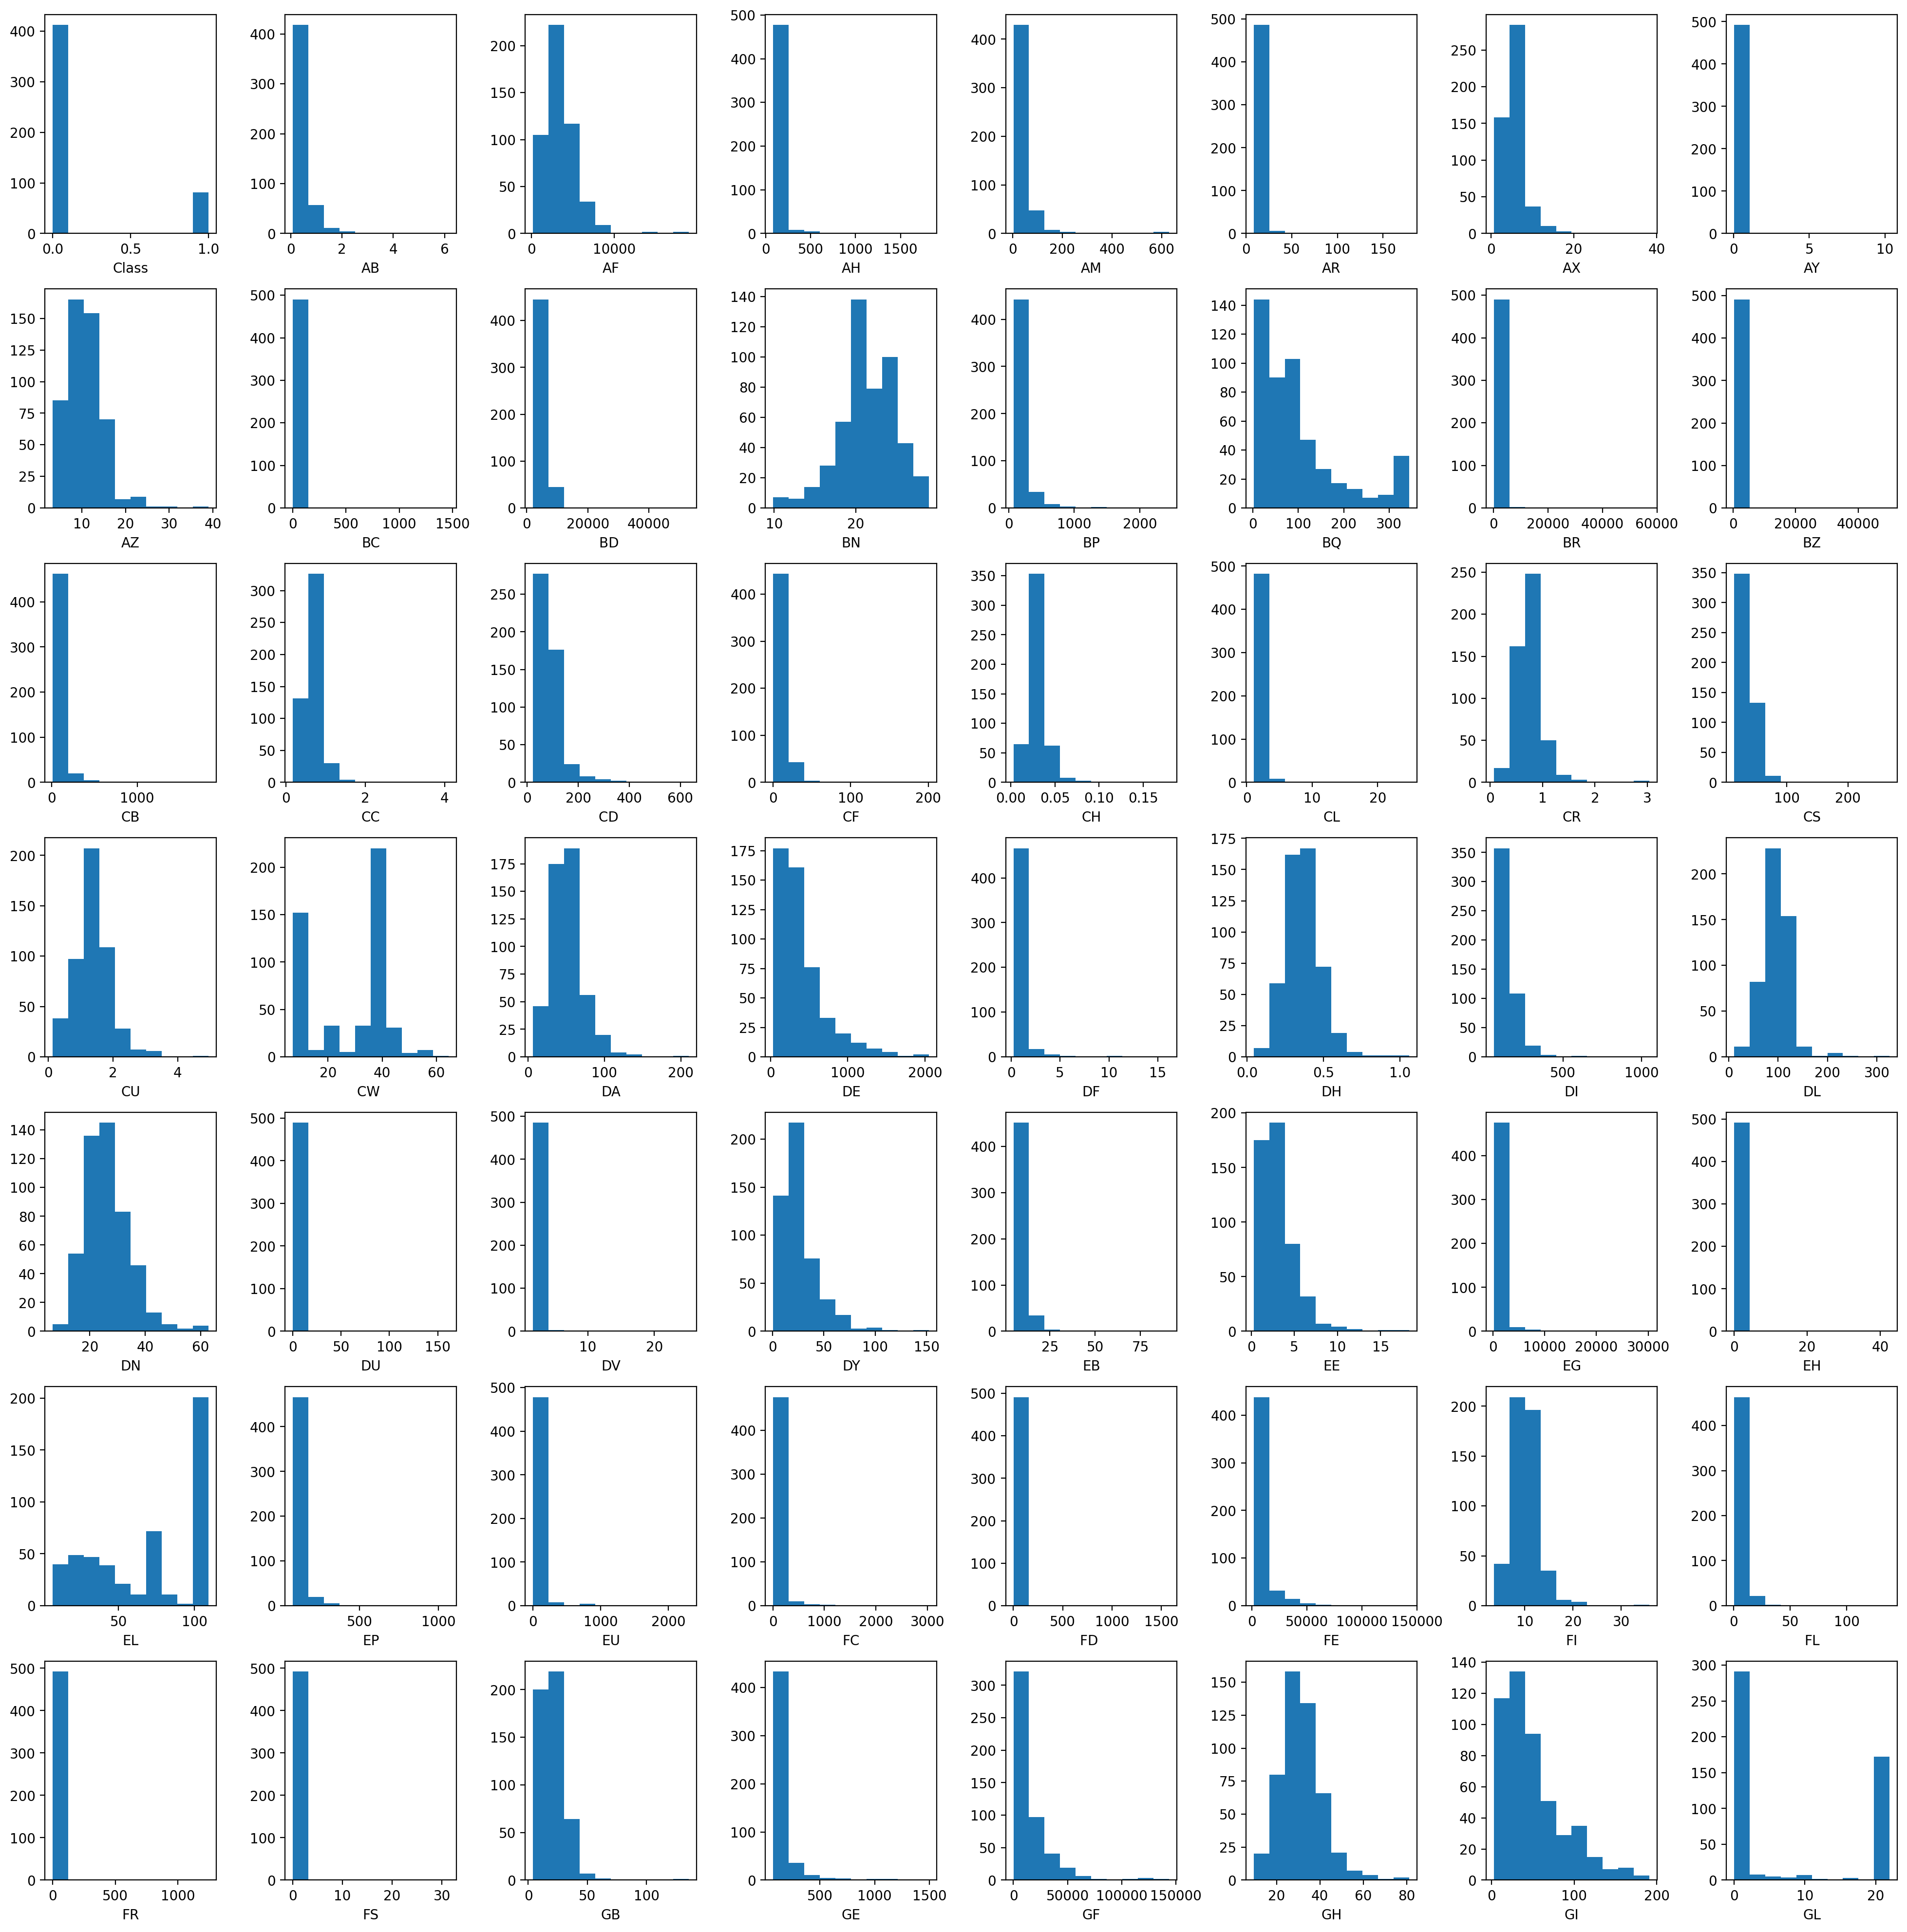

In [24]:
#check distributions of features and labels
columns = df_train.columns.tolist()

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(20, 20))
fig.tight_layout(pad=2.0)

for idx, ax in enumerate(axes.flatten()):
    if idx < len(columns):
        ax.hist(df_train[columns[idx]])
        ax.set_xlabel(columns[idx])
    else:
        ax.axis('off')

# Show the plot
plt.show()

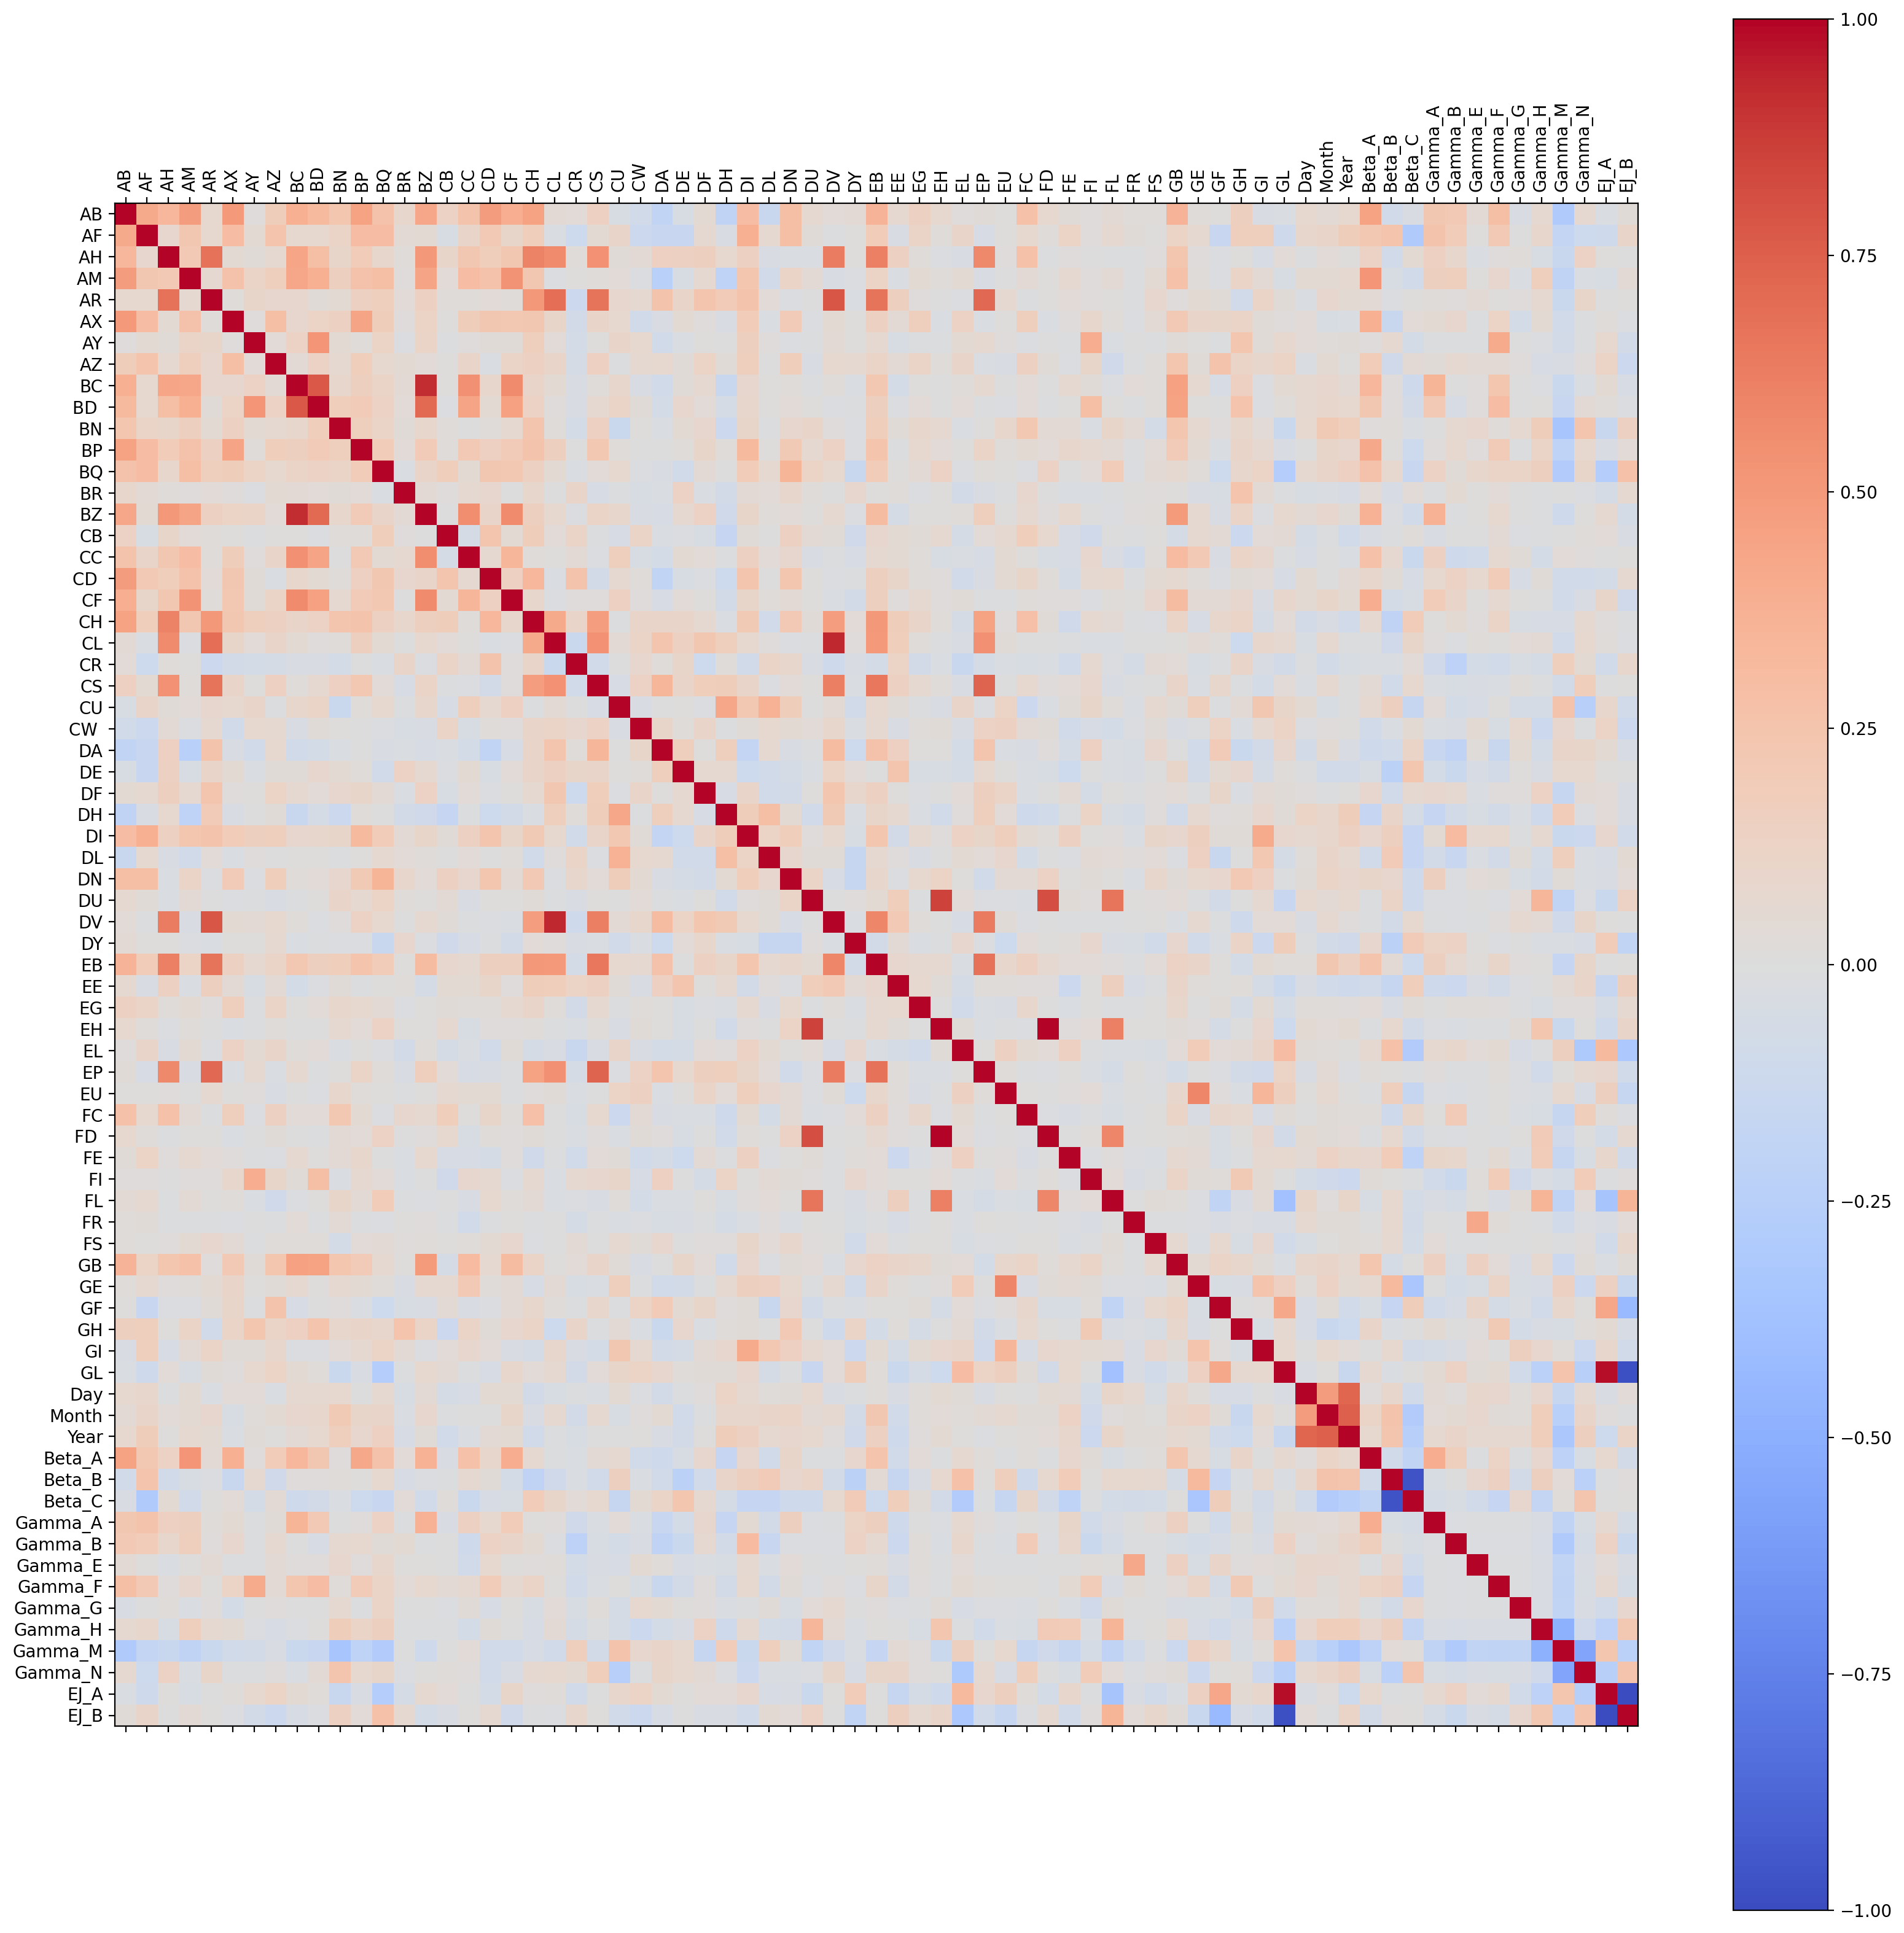

In [25]:
# bivariate interactions
FEATURE_COLUMNS = [i for i in df_train.columns if i not in ["Class"]]
feature_train_df = df_train[FEATURE_COLUMNS]
corr = feature_train_df.corr()
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(feature_train_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(feature_train_df.columns)
ax.set_yticklabels(feature_train_df.columns)
plt.show()

## Step 6: Feature Engineering

---

``PCA``

In [52]:
#highly correlated variables

corr_matrix = feature_train_df.corr().abs()

# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
high_corr
# df.drop(high_corr, axis=1, inplace=True)#if we want to drop the highly correlated vars (but I think running PCA makes more sense)



['FD ', 'Beta_C', 'EJ_A', 'EJ_B']

In [27]:
# 1. Standardize features

X_train = df_train.drop(["Class"], axis=1)
sc = StandardScaler()
sc.fit(X_train)
print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Mean:  [4.73995309e-01 3.52369784e+03 1.17705642e+02 3.73956814e+01
 9.74525601e+00 5.66453085e+00 6.45527647e-02 1.06092764e+01
 8.84355479e+00 5.40550072e+03 2.13822462e+01 2.33641053e+02
 1.00603667e+02 9.57258281e+02 5.78611730e+02 7.74330448e+01
 6.89036260e-01 9.19602651e+01 1.14518478e+01 3.03158134e-02
 1.35025793e+00 7.44950203e-01 3.66304823e+01 1.38264637e+00
 2.72535424e+01 5.15383233e+01 4.03948045e+02 5.51687276e-01
 3.65393230e-01 1.46109833e+02 9.50824515e+01 2.63914117e+01
 1.73820661e+00 1.89963891e+00 2.65359479e+01 9.02618725e+00
 3.05874815e+00 1.79172316e+03 2.87614004e-01 7.05769923e+01
 1.03934698e+02 5.04195517e+01 7.60183145e+01 7.05509486e+00
 9.90161351e+03 1.01657651e+01 5.35108465e+00 3.97179118e+00
 4.46079988e-01 2.09231414e+01 1.31453159e+02 1.50414441e+04
 3.12182843e+01 5.06481475e+01 8.26188144e+00 1.36105477e+01
 4.47870183e+00 1.50693103e+03 1.62271805e-02 3.16430020e-01
 6.67342799e-01 1.41987830e-02 3.24543611e-02 1.21703854e-02
 1.41987830e-02 1

/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
# 2. Construct the covariance matrix
cov_matrix = np.cov(X_train_std.T)
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,1.002033,0.408094,0.329123,0.479242,0.077345,0.497854,0.010863,0.173769,0.383096,0.314096,0.230189,0.449413,0.260603,0.087139,0.429833,0.125479,0.252854,0.483440,0.384158,0.448481,0.044643,0.032150,0.141613,-0.043146,-0.087284,-0.182960,-0.043381,0.053548,-0.197493,0.293876,-0.140474,0.282443,0.060086,0.034925,0.040655,0.352852,0.058851,0.134141,0.075156,0.013959,0.029446,0.007535,0.272715,0.072701,0.028140,0.015082,0.041475,0.021537,0.021587,0.355374,0.023418,0.000886,0.153649,-0.031941,-0.024371,0.073084,0.044734,0.071367,0.449352,-0.085265,-0.036334,0.222807,0.208524,0.043945,0.283874,-0.038726,0.061865,-0.300497,0.062025,-0.023848,0.023848
1,0.408094,1.002033,0.081948,0.222063,0.070491,0.291413,0.051391,0.243220,0.071334,0.074245,0.117346,0.297043,0.293670,0.040337,0.054050,-0.043320,0.107309,0.205715,0.101729,0.165283,-0.030307,-0.115325,0.051837,0.104575,-0.123343,-0.141079,-0.141486,0.069746,-0.031842,0.379126,0.062056,0.282881,0.030581,-0.013523,0.002884,0.184221,-0.037118,0.115629,0.016463,0.105569,-0.051986,0.002321,0.070841,0.019249,0.117607,0.009016,0.059126,0.023602,0.002132,0.122448,0.063813,-0.146329,0.161599,0.163113,-0.109582,0.092725,0.107599,0.176305,0.217695,0.245672,-0.300878,0.257972,0.183669,0.006019,0.203814,-0.006860,0.093569,-0.175811,-0.113275,-0.102950,0.102950
2,0.329123,0.081948,1.002033,0.208435,0.677575,0.054186,0.030651,0.069251,0.436309,0.286490,0.099196,0.181240,0.090497,0.021825,0.502502,0.100487,0.226092,0.165827,0.226315,0.608776,0.565318,0.021546,0.533936,0.027448,0.043333,0.147776,0.137635,0.155466,0.072334,0.136246,-0.034557,-0.030359,-0.029715,0.630017,0.004536,0.613354,0.133195,0.015798,-0.022280,-0.036932,0.577322,0.009772,0.268710,-0.013684,0.013020,-0.002215,-0.015022,-0.010583,0.012147,0.228042,0.009522,-0.017922,0.001146,-0.053284,0.037470,-0.008365,0.037873,0.006076,0.128933,-0.090184,0.054445,0.145346,0.088941,-0.023705,0.012486,0.020951,-0.041388,-0.139150,0.126922,0.006944,-0.006944
3,0.479242,0.222063,0.208435,1.002033,0.068662,0.259098,0.110785,0.157496,0.427680,0.380073,0.156552,0.261333,0.287028,0.010802,0.444200,0.031503,0.289899,0.265496,0.526185,0.219624,-0.018885,0.003359,0.021446,0.037458,-0.023055,-0.242279,-0.043925,0.059834,-0.210551,0.229680,-0.085707,0.116457,0.046110,-0.034801,-0.018861,0.122279,-0.029750,0.047172,0.020088,0.050037,-0.031342,-0.007289,0.043966,0.007422,0.058869,0.011256,0.045789,-0.008670,0.048658,0.270109,0.016614,-0.019518,0.111794,0.045263,-0.043933,0.047834,0.050453,0.062587,0.518087,-0.046247,-0.093281,0.151517,0.160917,0.005093,0.084445,-0.030774,0.156886,-0.200179,-0.024048,-0.041134,0.041134
4,0.077345,0.070491,0.677575,0.068662,1.002033,0.019748,0.094960,0.079807,0.078509,0.028643,0.054163,0.137760,0.162146,0.038077,0.138000,0.020581,0.016482,0.035334,0.018126,0.503534,0.691036,-0.123284,0.667273,0.083769,0.065107,0.251036,0.104749,0.238070,0.195048,0.252315,0.038020,-0.021659,-0.000524,0.790277,-0.025724,0.666281,0.150029,0.014654,-0.001104,-0.019910,0.719264,0.056586,-0.013874,0.007035,0.037214,0.014208,0.002558,-0.008338,0.080006,0.008492,0.053791,0.026306,-0.090587,0.111746,0.027578,-0.025143,0.085164,0.052233,0.041636,-0.015772,0.004404,0.016899,0.012248,0.044128,0.005714,0.013349,0.058266,-0.127117,0.096576,-0.005267,0.005267
5,0.497854,0.291413,0.054186,0.259098,0.019748,1.002033,0.015243,0.289310,0.083297,0.117984,0.135175,0.440509,0.178740,0.008058,0.119544,0.007578,0.178223,0.225152,0.214393,0.226554,0.101745,-0.072572,0.109567,0.075775,-0.082975,-0.033301,0.053667,0.009669,-0.038462,0.181411,-0.028052,0.191319,-0.023234,0.053986,0.004795,0.138298,0.045902,0.162177,-0.027645,0.130713,-0.029183,0.006147,0.159149,-0.031306,0.014375,0.090080,0.018465,-0.017103,0.039219,0.211213,0.109222,0.094771,0.116713,0.025359,0.011304,0.03

In [29]:
#3. Decompose into eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

In [30]:
#rank them in decreasing order 
# compute the explained variance ratio
sum_eigen_values = sum(eigen_values)
print('Sum eigenvalues: ', sum_eigen_values)

expl_var_ratio = [i/sum_eigen_values for i in sorted(eigen_values, reverse=True)]
print('\nExplained variance ratio:')
pd.DataFrame(expl_var_ratio)

Sum eigenvalues:  71.14430894308946

Explained variance ratio:


,0
0,9.837275e-02
1,7.223816e-02
2,6.524451e-02
3,5.313457e-02
4,4.142368e-02
5,3.945206e-02
6,3.725787e-02
7,2.976654e-02
8,2.837909e-02
9,2.615625e-02


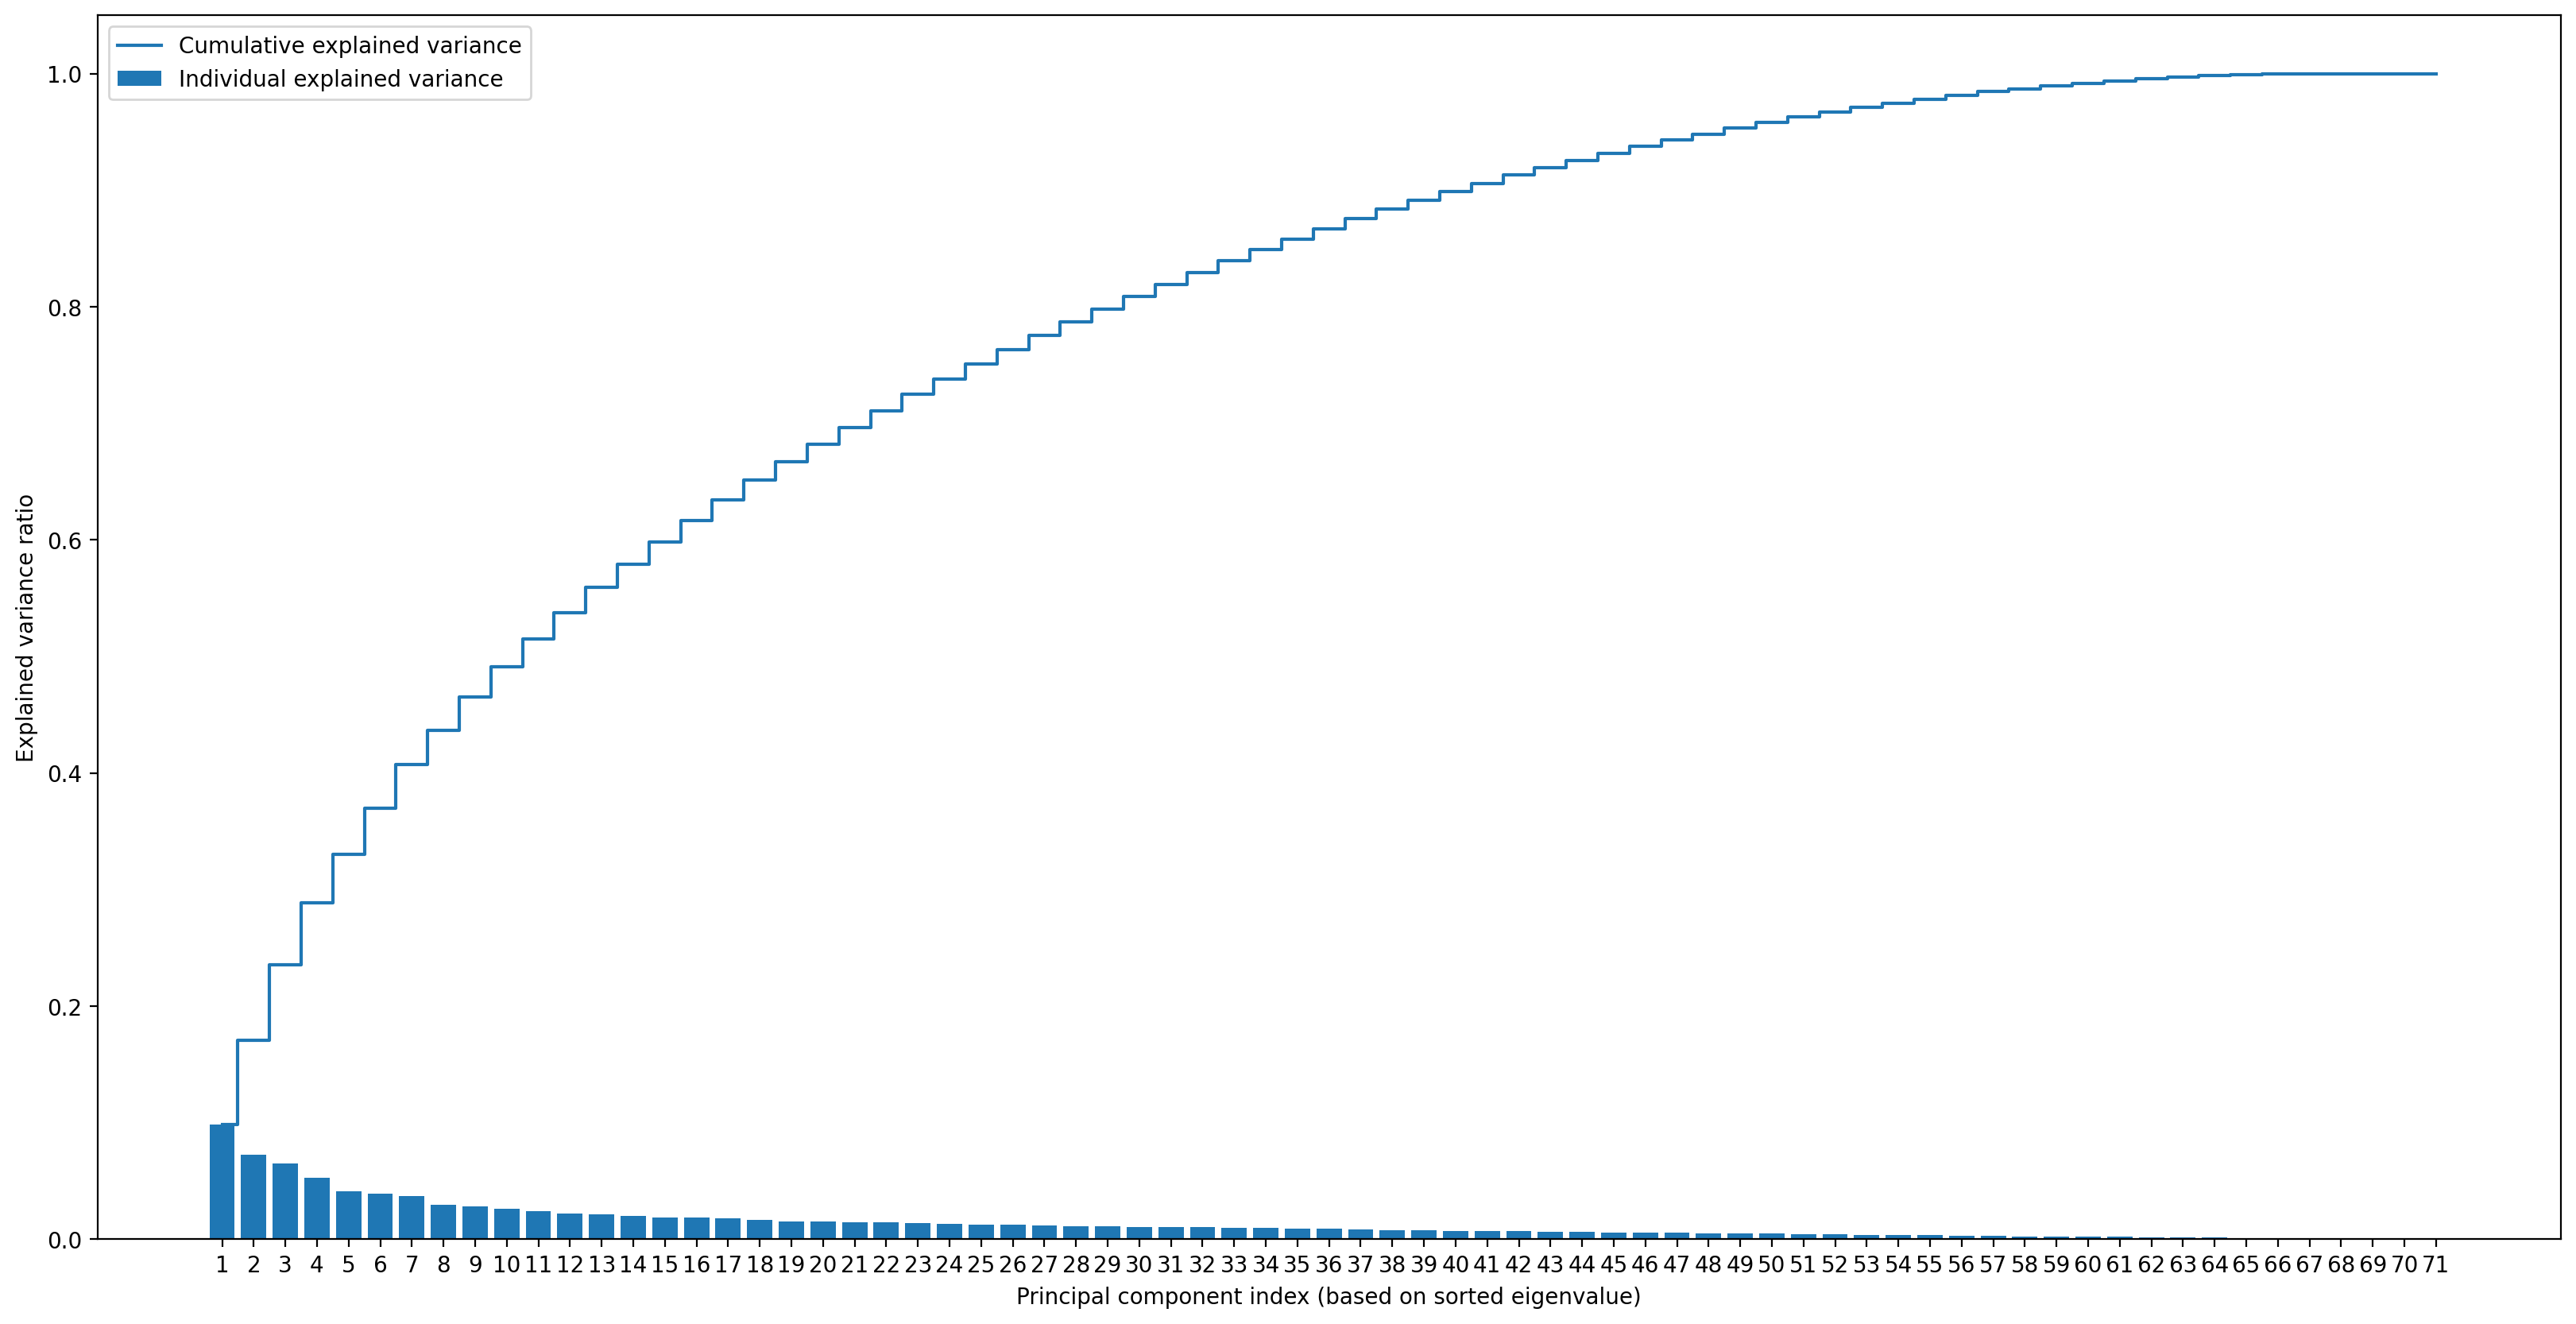

In [31]:
# visualize the explained variance ratio and the cumulative explained variance ratio
x_axis = range(1,len(eigen_values)+1)
y_axis = expl_var_ratio

# plot individual ratio
plt.rcParams["figure.figsize"] = (20, 10)
plt.bar(x_axis, y_axis, label='Individual explained variance')
# plot cumulative ratio
plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

# legend, labels
plt.legend()
plt.xticks(x_axis)
plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

In [32]:
#select k=10  eigenvectors, based on the 6 largest eigenvalues, explaining around half the variability 
# create eigen pairs of vectors and values
eigen_pairs = [(eigen_values[i], eigen_vectors[:,i]) for i in range(len(eigen_vectors))]

# transform to df
eigen_pairs = pd.DataFrame(eigen_pairs)
eigen_pairs.rename(columns={0: 'eigen_value', 1: 'eigen_vector'}, inplace=True)
# eigen_pairs.head()

# select the top 10 eigenvectors based on the eigenvalue
top10_eigen_vectors = eigen_pairs.nlargest(10, 'eigen_value')['eigen_vector'].values.tolist()
top10_eigen_vectors

[array([-0.25657549, -0.14200925, -0.26752627, -0.20141144, -0.21431955,
        -0.15090907, -0.07523306, -0.09975664, -0.22668679, -0.20488107,
        -0.10924461, -0.19022551, -0.13997626, -0.02168587, -0.24419241,
        -0.03169617, -0.14612947, -0.11366666, -0.1828209 , -0.22204097,
        -0.17219373,  0.02940594, -0.19156599, -0.03743865, -0.01045803,
        -0.00992811, -0.01750441, -0.08155028,  0.00830097, -0.14730944,
         0.00402885, -0.0840787 , -0.03475646, -0.18266284,  0.01138735,
        -0.262373  , -0.02971527, -0.04342985, -0.03329737, -0.01136853,
        -0.16624627, -0.02680427, -0.0748905 , -0.03240707, -0.03278115,
        -0.0367649 , -0.02692688,  0.0005713 , -0.02224629, -0.16507161,
        -0.04199239,  0.00096503, -0.05300135, -0.03096551, -0.00109013,
        -0.03790192, -0.08156584, -0.06740658, -0.18311378,  0.00054678,
         0.04856429, -0.10948128, -0.051776  , -0.01837568, -0.09366579,
        -0.0020872 , -0.04382123,  0.13640909, -0.0

In [33]:
# Construct the projection matrix, W, using the top 10 eigenvectors

w = np.hstack((top10_eigen_vectors[0][:, np.newaxis],
               top10_eigen_vectors[1][:, np.newaxis],
               top10_eigen_vectors[2][:, np.newaxis],
               top10_eigen_vectors[3][:, np.newaxis],
               top10_eigen_vectors[4][:, np.newaxis],
               top10_eigen_vectors[5][:, np.newaxis],
               top10_eigen_vectors[6][:, np.newaxis],
               top10_eigen_vectors[7][:, np.newaxis],
               top10_eigen_vectors[8][:, np.newaxis],
               top10_eigen_vectors[9][:, np.newaxis]
              ))
print('Matrix W:\n', w)
print('\nSize of Matrix W: ', w.shape)

Matrix W:
 [[-0.25657549  0.13390783 -0.03711281  0.10725532  0.07758336 -0.12861729
   0.14767687 -0.02902825  0.05486818 -0.07248882]
 [-0.14200925  0.14355309  0.00522121 -0.10979085 -0.0462853  -0.14134557
   0.20678865 -0.07910817 -0.08238048  0.13564446]
 [-0.26752627 -0.18400186  0.03031578  0.04659823 -0.02870903  0.06000344
  -0.06603973 -0.09949675  0.04651576 -0.12240944]
 [-0.20141144  0.16349047 -0.06574538  0.08809694  0.01554419 -0.0119451
   0.01458301 -0.0941492   0.07286946  0.02697882]
 [-0.21431955 -0.26859465  0.10444643 -0.10676678 -0.03998996  0.01038554
  -0.00952415 -0.08459614 -0.0449583   0.02471718]
 [-0.15090907  0.06686049 -0.05793346  0.05566171  0.06618034 -0.10283348
   0.22895782  0.06120907  0.02527101  0.22751266]
 [-0.07523306  0.02906806 -0.06261262 -0.02074036 -0.01687002  0.08073384
  -0.01533367  0.1580251  -0.4665811  -0.12639902]
 [-0.09975664 -0.00821726 -0.07672453  0.01299078  0.09378693 -0.08960337
   0.10898102  0.1967918   0.00269464  0.

In [34]:
# 7. Transform original X-Train with the projection matrix
# training data
X_train_pca = X_train_std.dot(w)
pd.DataFrame(X_train_pca).head()


,0,1,2,3,4,5,6,7,8,9
0,0.003768,0.804002,1.372699,0.844143,-0.353523,-0.919119,0.421924,0.601139,1.428052,-0.931760
1,-7.160920,5.532525,-0.309784,2.163112,0.811577,-2.362351,0.906786,-1.729318,-0.498032,2.982415
2,-0.163571,-1.899644,-1.717446,-1.498297,0.217321,0.251951,-0.326478,1.532793,1.260573,0.564285
3,0.241319,-1.784804,-1.803843,-1.949877,-0.262721,0.547774,-1.531655,0.082415,-0.967453,-0.317559
4,-1.128778,1.653519,1.753170,0.085278,0.499221,-0.346470,0.891995,1.793798,0.690649,2.847811


In [35]:
df_train_pca = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train_pca)],
    axis=1
)



df_train_pca.columns=['Class', 'PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6','PCA_7','PCA_8','PCA_9','PCA_10']
df_train_pca.head()


,Class,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,0,0.003768,0.804002,1.372699,0.844143,-0.353523,-0.919119,0.421924,0.601139,1.428052,-0.931760
1,1,-7.160920,5.532525,-0.309784,2.163112,0.811577,-2.362351,0.906786,-1.729318,-0.498032,2.982415
2,0,-0.163571,-1.899644,-1.717446,-1.498297,0.217321,0.251951,-0.326478,1.532793,1.260573,0.564285
3,0,0.241319,-1.784804,-1.803843,-1.949877,-0.262721,0.547774,-1.531655,0.082415,-0.967453,-0.317559
4,1,-1.128778,1.653519,1.753170,0.085278,0.499221,-0.346470,0.891995,1.793798,0.690649,2.847811


In [36]:
# test data
X_test_pca = X_test_std.dot(w)
pd.DataFrame(X_test_pca).head()

,0,1,2,3,4,5,6,7,8,9
0,-3.034559,2.502419,1.755300,-0.887745,-0.231994,-2.154653,-1.541556,-3.578225,0.004617,0.616240
1,0.817705,1.464068,1.098364,-0.640218,-1.303453,-0.387996,-0.623712,-1.846377,0.233599,-0.750838
2,0.557601,0.181032,1.094001,-1.013532,-1.039634,1.454390,0.504704,0.601563,-0.088216,0.324593
3,0.399408,-1.216349,-1.842341,-0.388559,0.359324,0.101363,-0.703014,2.121091,0.737589,1.276012
4,0.515754,-0.510928,-2.328862,-0.393606,1.135039,-0.761038,-0.655611,1.382666,1.489513,-0.375076


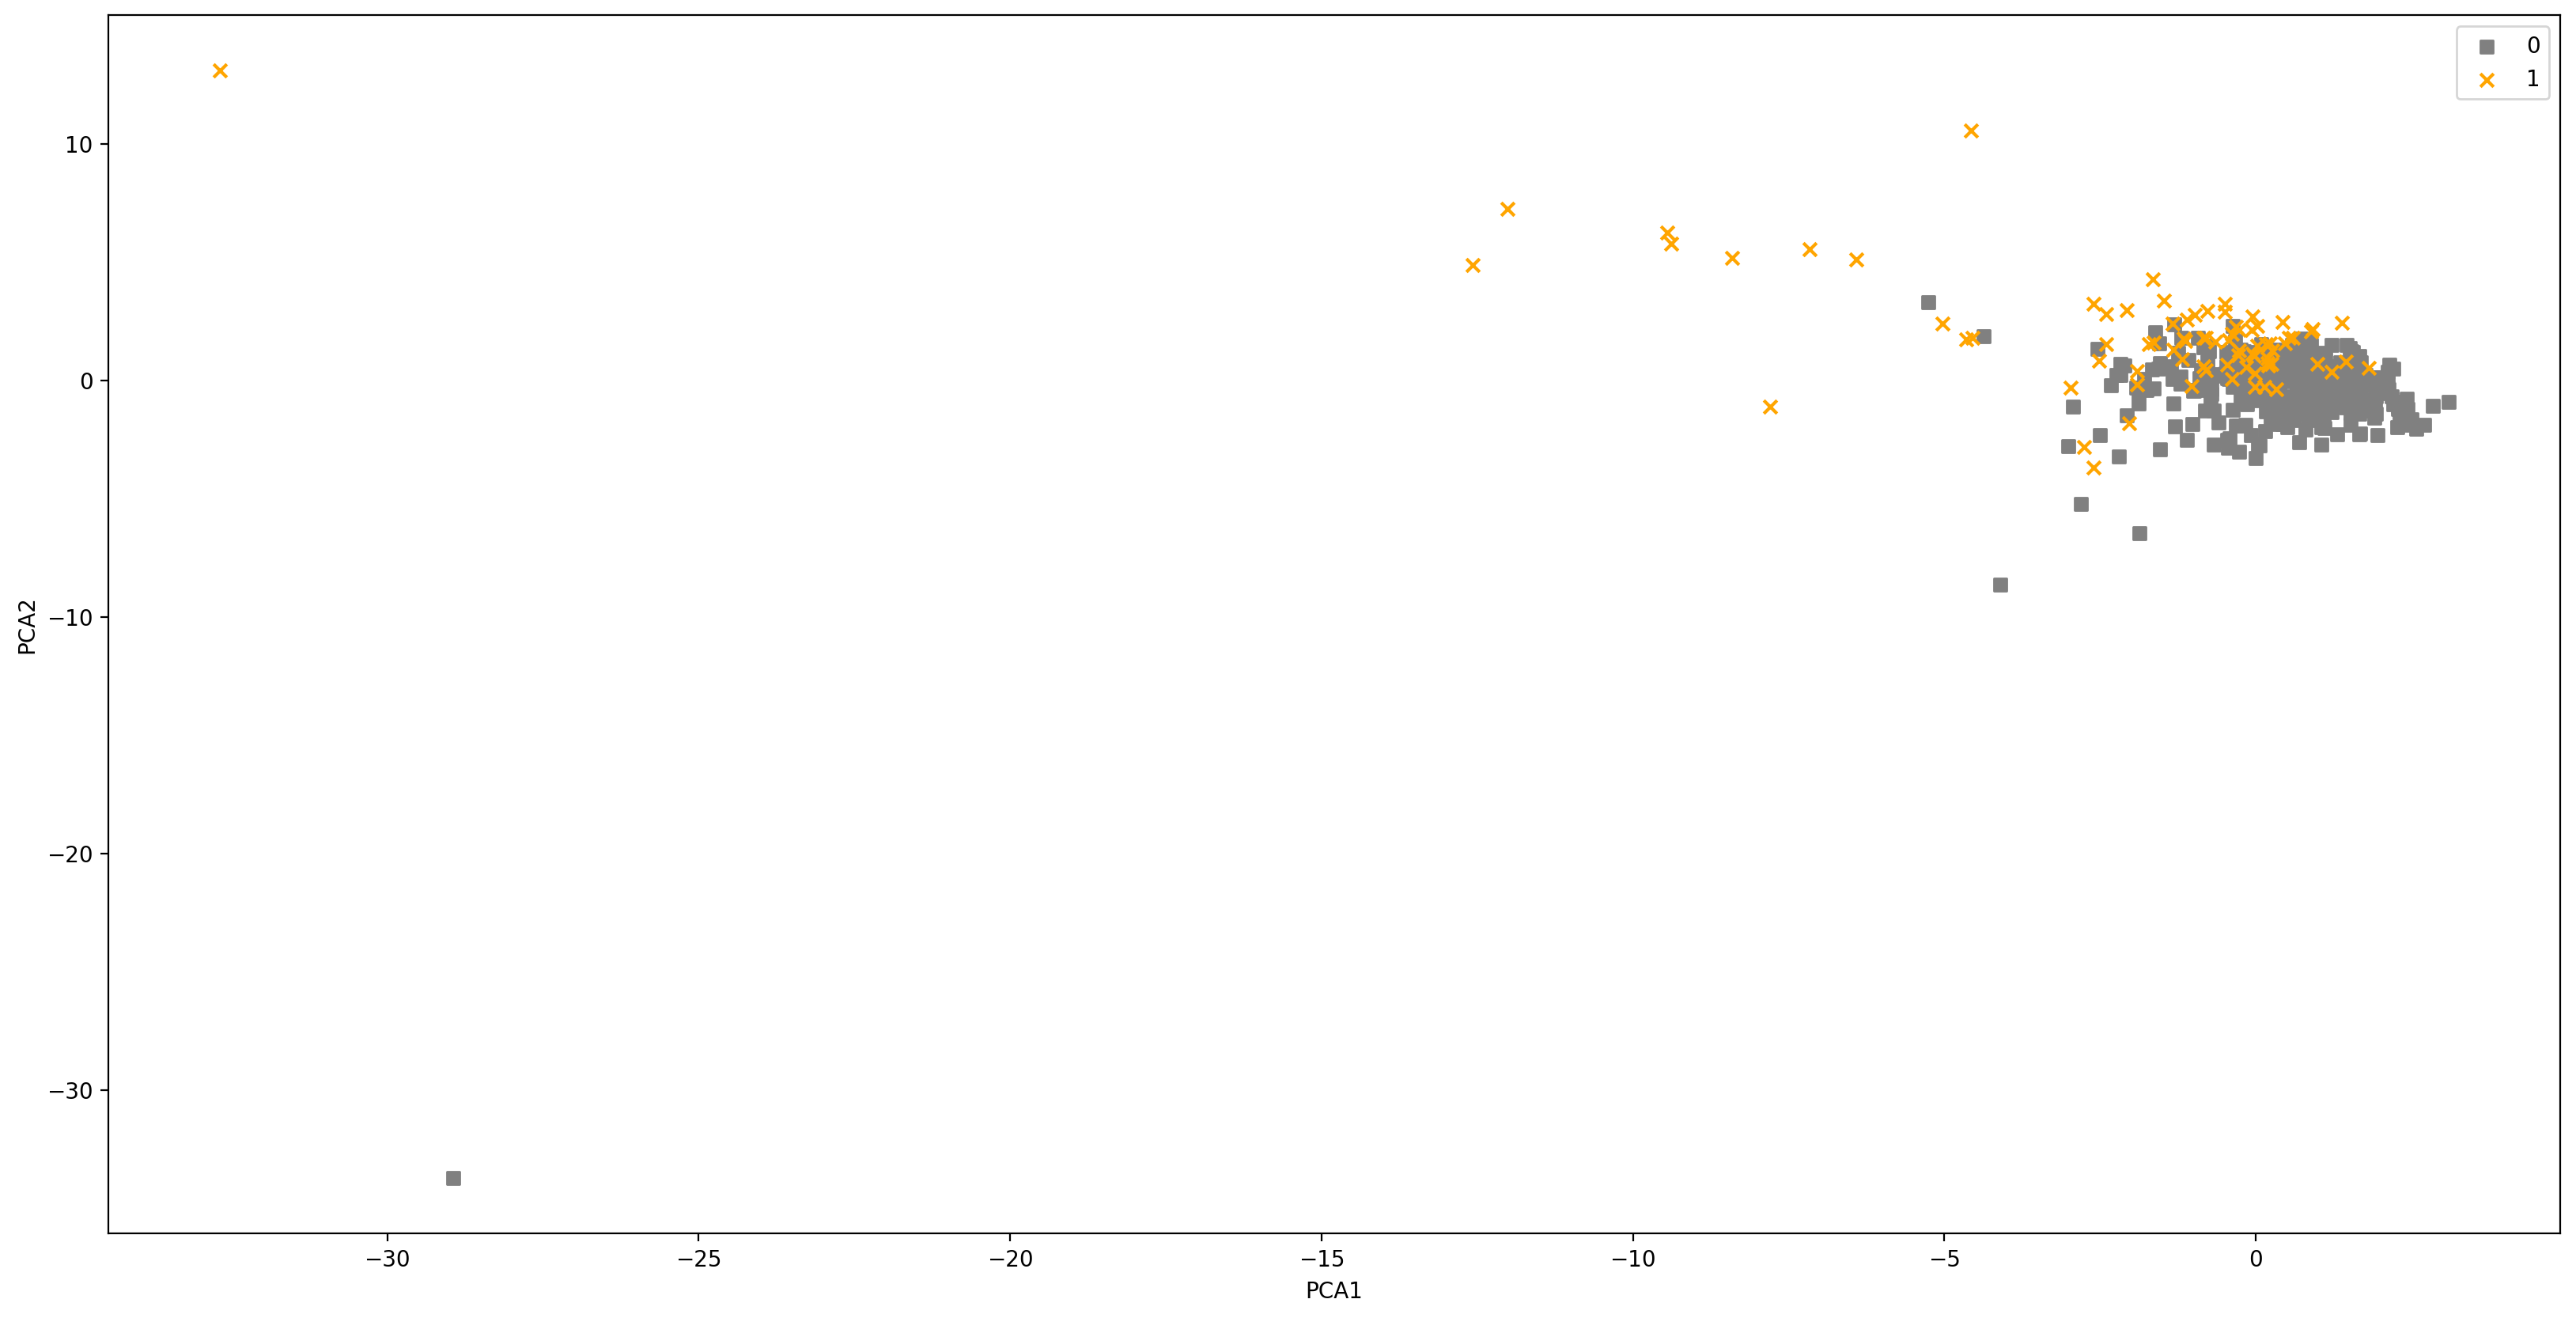

In [37]:
#visualize first 2 PCA 
colors = ['grey', 'orange', 'blue']
markers = ['s', 'x', 'o']

# plot
for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==class_value, 0],
                X_train_pca[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)
    
# legend, axes
plt.legend(loc='best')
plt.xlabel('PCA1')
plt.ylabel('PCA2');

``tSNE``

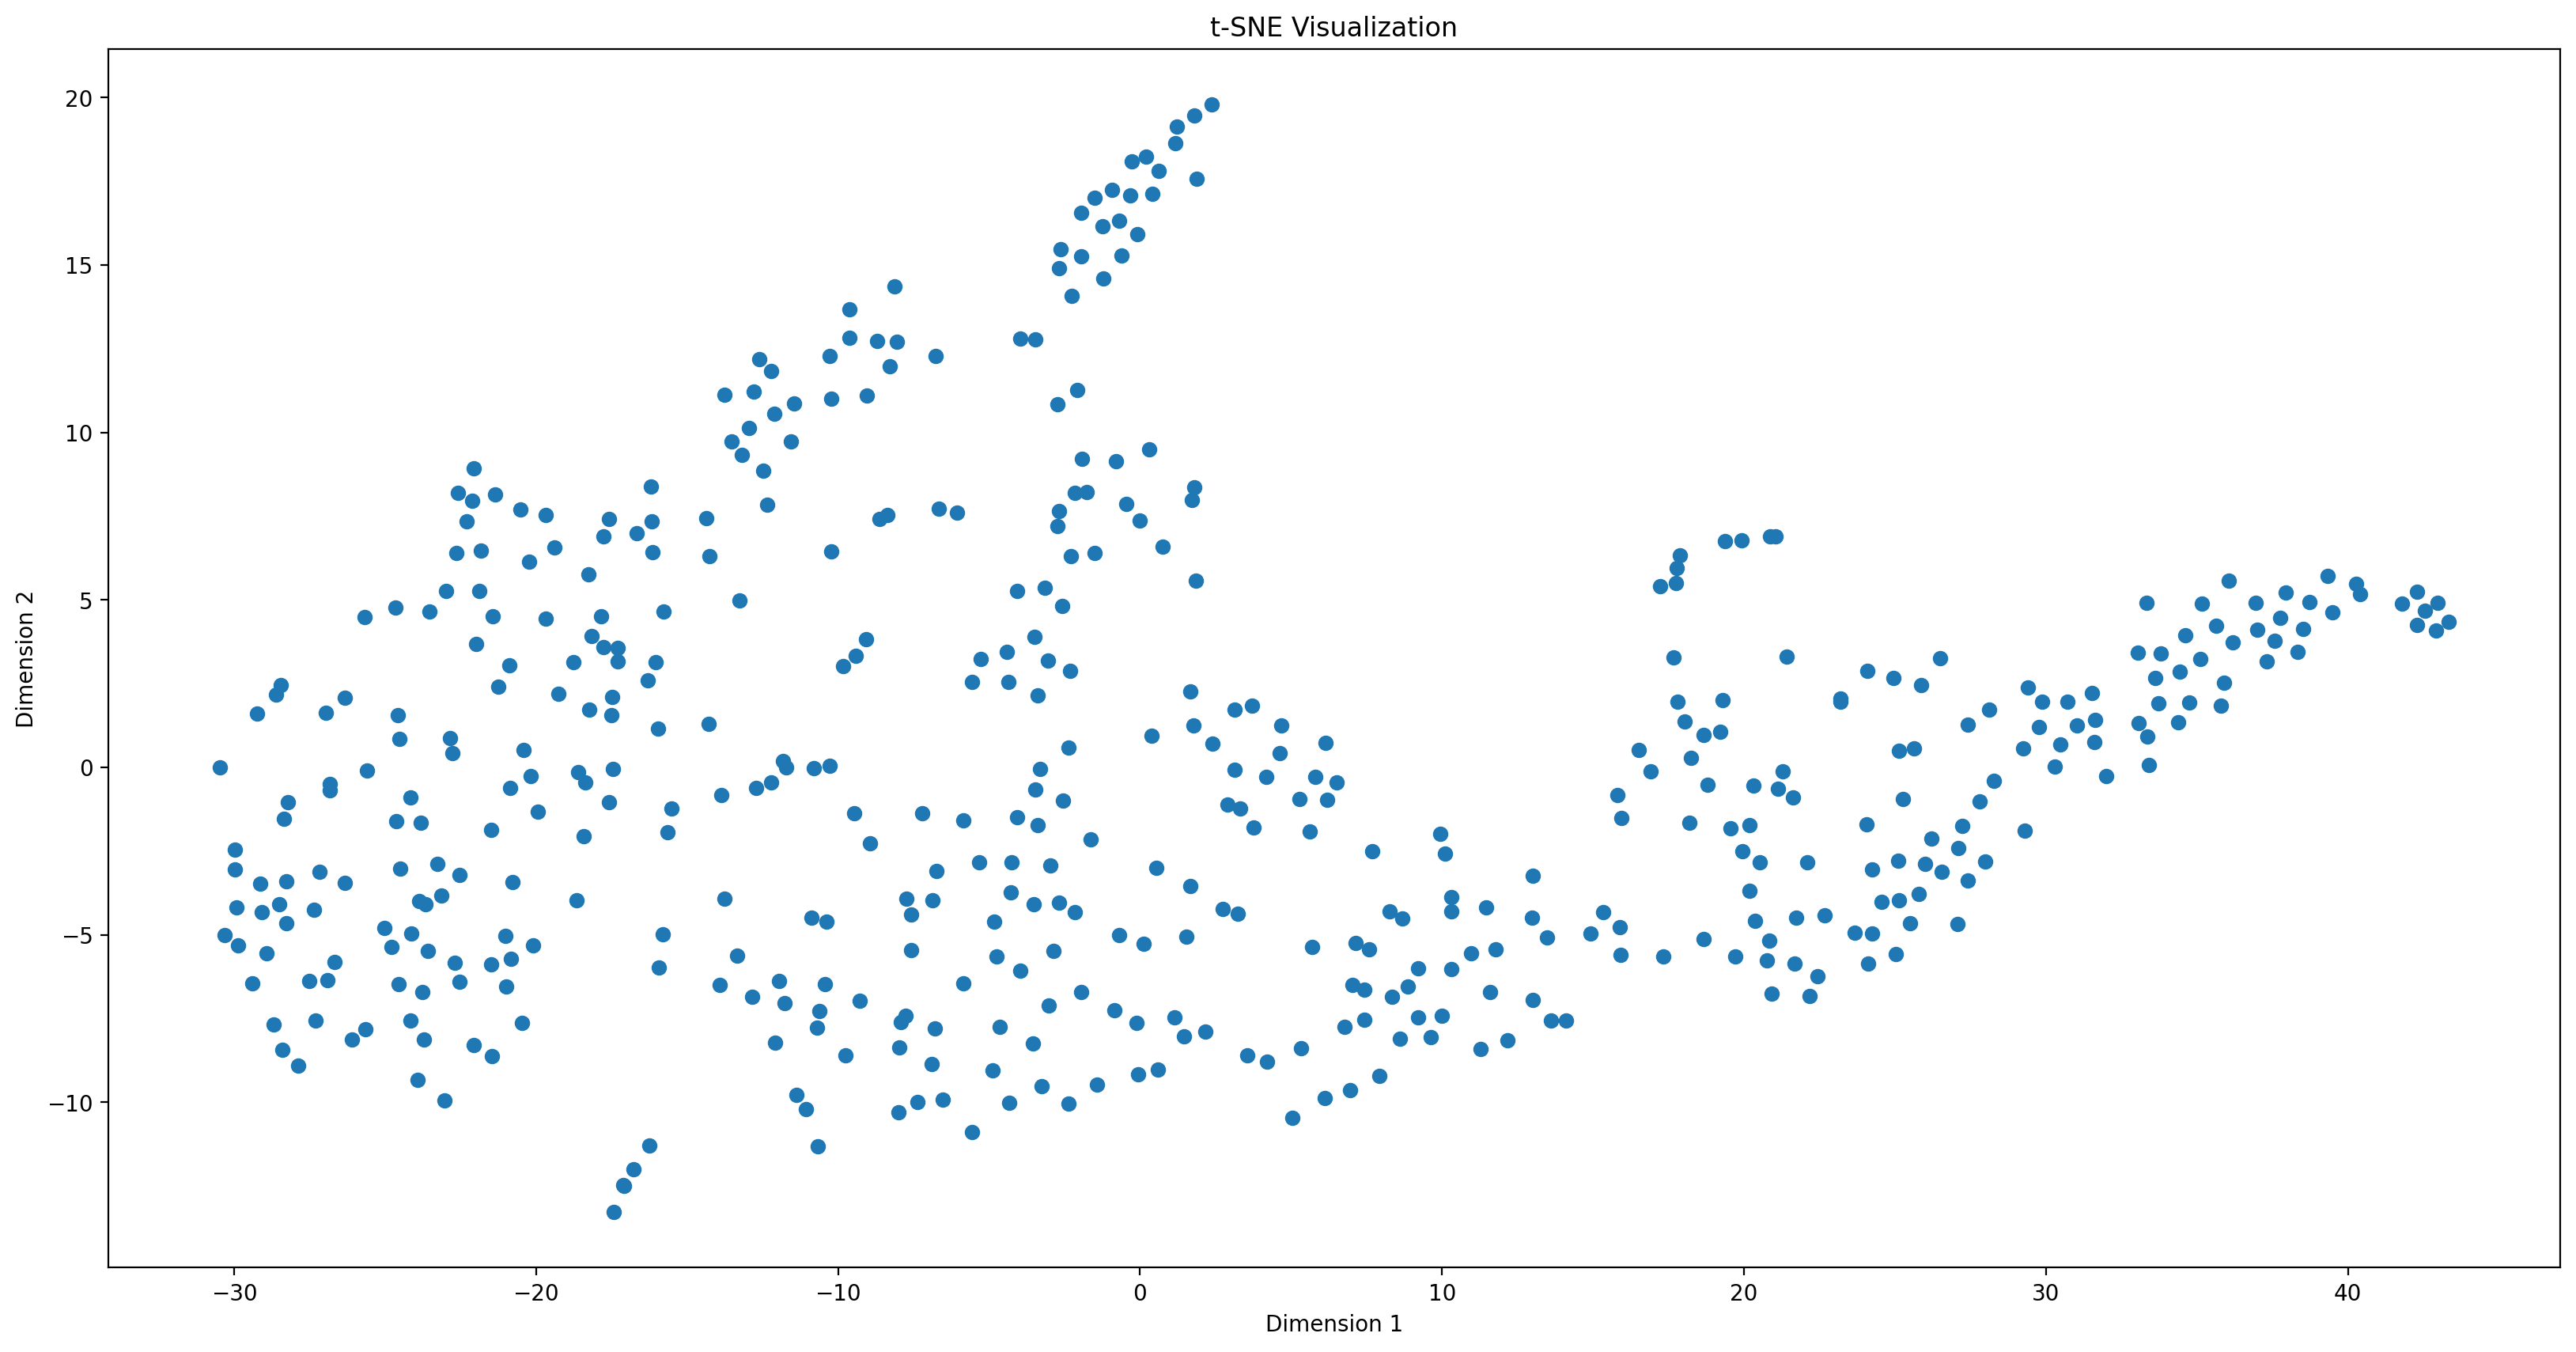

In [38]:
#create an instance of the tsne class
tsne = TSNE(n_components=2, random_state=42)

#fit the model to xTrain
tsne_X_train = tsne.fit_transform(X_train)

# Visualize the embedded data
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:, 1])
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Step 7: Learning Model

---

1. Class weighting
2. K-fold cross-validation
3. Hyperparameter tuning: Number of trees, depth of trees

``random forest with bagging``

In [39]:
#class weighting

# Calculate the number of samples for each label.
neg, pos = np.bincount(df_train_pca['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 3.04


``k-fold cross validation``

In [40]:
# len(df_train) #with raw data
len(df_train_pca) #with pca same length....

493

In [41]:
#estimate performance with OOF 
# Create list of ids for the creation of oof dataframe.
ID_LIST = df_train_pca.index


# # Create a dataframe of required size with zero values (493)
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
accuracy = {}
cross_entropy = {}
# auprc = {} can't get it to work, will try later


# Save the name of the label column to a variable.
label = "Class"

In [42]:
kf = KFold(n_splits=10)
ft_cols = df_train_pca.columns
ft_cols

Index(['Class', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9', 'PCA_10'],
      dtype='object')

`Build the model` 



In [43]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = df_train_pca.iloc[train_index]
        valid_df = df_train_pca.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[ft_cols]
        valid_df = valid_df[ft_cols]
        

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()

##### Fold 1
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3246ff1y as temporary training directory
##### Fold 2
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3hdvxaq4 as temporary training directory


##### Fold 3
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpnv3y18pp as temporary training directory
##### Fold 4
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpjl3mckp9 as temporary training directory
##### Fold 5
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpfm571now as temporary training directory
##### Fold 6
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpp2wozhk_ as temporary training directory
##### Fold 7
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcfdkn0jx as temporary training directory
##### Fold 8
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpn_8wwdcb as temporary training directory
##### Fold 9
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp59ud1qzk as temporary training directory
##### Fold 10
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a as temporary training directory


`Compile the model `

In [44]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):
    rf.compile(metrics=[tf.keras.metrics.AUC(curve="PR")]) #change from accuracy to AUPRC and balanced log-loss

`Fit the model `

In [45]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):

    rf.fit(x=train_ds, class_weight=class_weight)
            
    # Store the model
    models[f"fold_{i+1}"] = rf
            
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
            
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten() 
            
    # Evaluate and store the metrics in respective dicts
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

Reading training dataset...


2023-07-16 19:57:43.709615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype double and shape [2]
	 [[{{node Placeholder/_17}}]]


Training dataset read in 0:00:05.550087. Found 444 examples.
Training model...
Model trained in 0:00:00.109983
Compiling model...


[INFO 23-07-16 19:57:49.2731 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:49.3087 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:49.3087 -05 abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-07-16 19:57:49.3088 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:49.330226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [444]
	 [[{{node Placeholder/_9}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 81ms/step


2023-07-16 19:57:51.327441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [49]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 638ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.066468. Found 444 examples.
Training model...
Model trained in 0:00:00.097688
Compiling model...


2023-07-16 19:57:52.088513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype double and shape [444]
	 [[{{node Placeholder/_6}}]]
[INFO 23-07-16 19:57:52.1843 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:52.2144 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:52.2144 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:52.228246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dty

Model compiled.
1/1 [==============================] - 0s 192ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.070527. Found 444 examples.
Training model...
Model trained in 0:00:00.091476
Compiling model...


2023-07-16 19:57:52.804477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [444]
	 [[{{node Placeholder/_4}}]]
[INFO 23-07-16 19:57:52.8955 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:52.9279 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:52.9279 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:52.943808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dty

Model compiled.


1/1 [==============================] - 0s 188ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.067301. Found 444 examples.
Training model...
Model trained in 0:00:00.124398
Compiling model...


2023-07-16 19:57:53.402292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [444]
	 [[{{node Placeholder/_7}}]]
[INFO 23-07-16 19:57:53.5124 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:53.5525 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:53.5526 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:53.567214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dty

Model compiled.
1/1 [==============================] - 0s 178ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.067796. Found 444 examples.
Training model...
Model trained in 0:00:00.119132
Compiling model...


2023-07-16 19:57:54.146931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [444]
	 [[{{node Placeholder/_5}}]]
[INFO 23-07-16 19:57:54.2622 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:54.2956 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:54.2956 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:54.312656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dty

Model compiled.
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 210ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.066498. Found 444 examples.
Training model...
Model trained in 0:00:00.095227
Compiling model...


2023-07-16 19:57:54.765748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [444]
	 [[{{node Placeholder/_2}}]]
[INFO 23-07-16 19:57:54.8602 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:54.8890 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:54.8890 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:54.902700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dty

Model compiled.
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 188ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.062600. Found 444 examples.
Training model...
Model trained in 0:00:00.082907
Compiling model...


2023-07-16 19:57:55.311658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [444]
	 [[{{node Placeholder/_10}}]]
[INFO 23-07-16 19:57:55.3948 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:55.4191 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:55.4192 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:55.430969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dt

Model compiled.
1/1 [==============================] - 0s 155ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.068020. Found 444 examples.
Training model...
Model trained in 0:00:00.093343
Compiling model...


2023-07-16 19:57:55.813393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [444]
	 [[{{node Placeholder/_9}}]]
[INFO 23-07-16 19:57:55.9164 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:55.9476 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:55.9476 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:55.961520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dty

Model compiled.
1/1 [==============================] - 0s 137ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.052221. Found 444 examples.
Training model...
Model trained in 0:00:00.073199
Compiling model...
Model compiled.


2023-07-16 19:57:56.301760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype double and shape [444]
	 [[{{node Placeholder/_6}}]]
[INFO 23-07-16 19:57:56.3785 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:56.3989 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:56.3989 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:56.408830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dty

1/1 [==============================] - 0s 180ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278
Reading training dataset...
Training dataset read in 0:00:00.069297. Found 444 examples.
Training model...
Model trained in 0:00:00.088872
Compiling model...


2023-07-16 19:57:56.771808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [444]
	 [[{{node Placeholder/_4}}]]
[INFO 23-07-16 19:57:56.8604 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp3xt76q_a/model/ with prefix d7c4727aab904b96
[INFO 23-07-16 19:57:56.8885 -05 decision_forest.cc:660] Model loaded with 300 root(s), 8350 node(s), and 10 input feature(s).
[INFO 23-07-16 19:57:56.8886 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 19:57:56.899371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dty

Model compiled.
1/1 [==============================] - 0s 148ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1278


`Visualize the model`

In [46]:
with open("fold_1.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_1'], tree_idx=0, max_depth=3))


with open("fold_2.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_2'], tree_idx=0, max_depth=3))


with open("fold_3.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_3'], tree_idx=0, max_depth=3))   



`Plot loss`

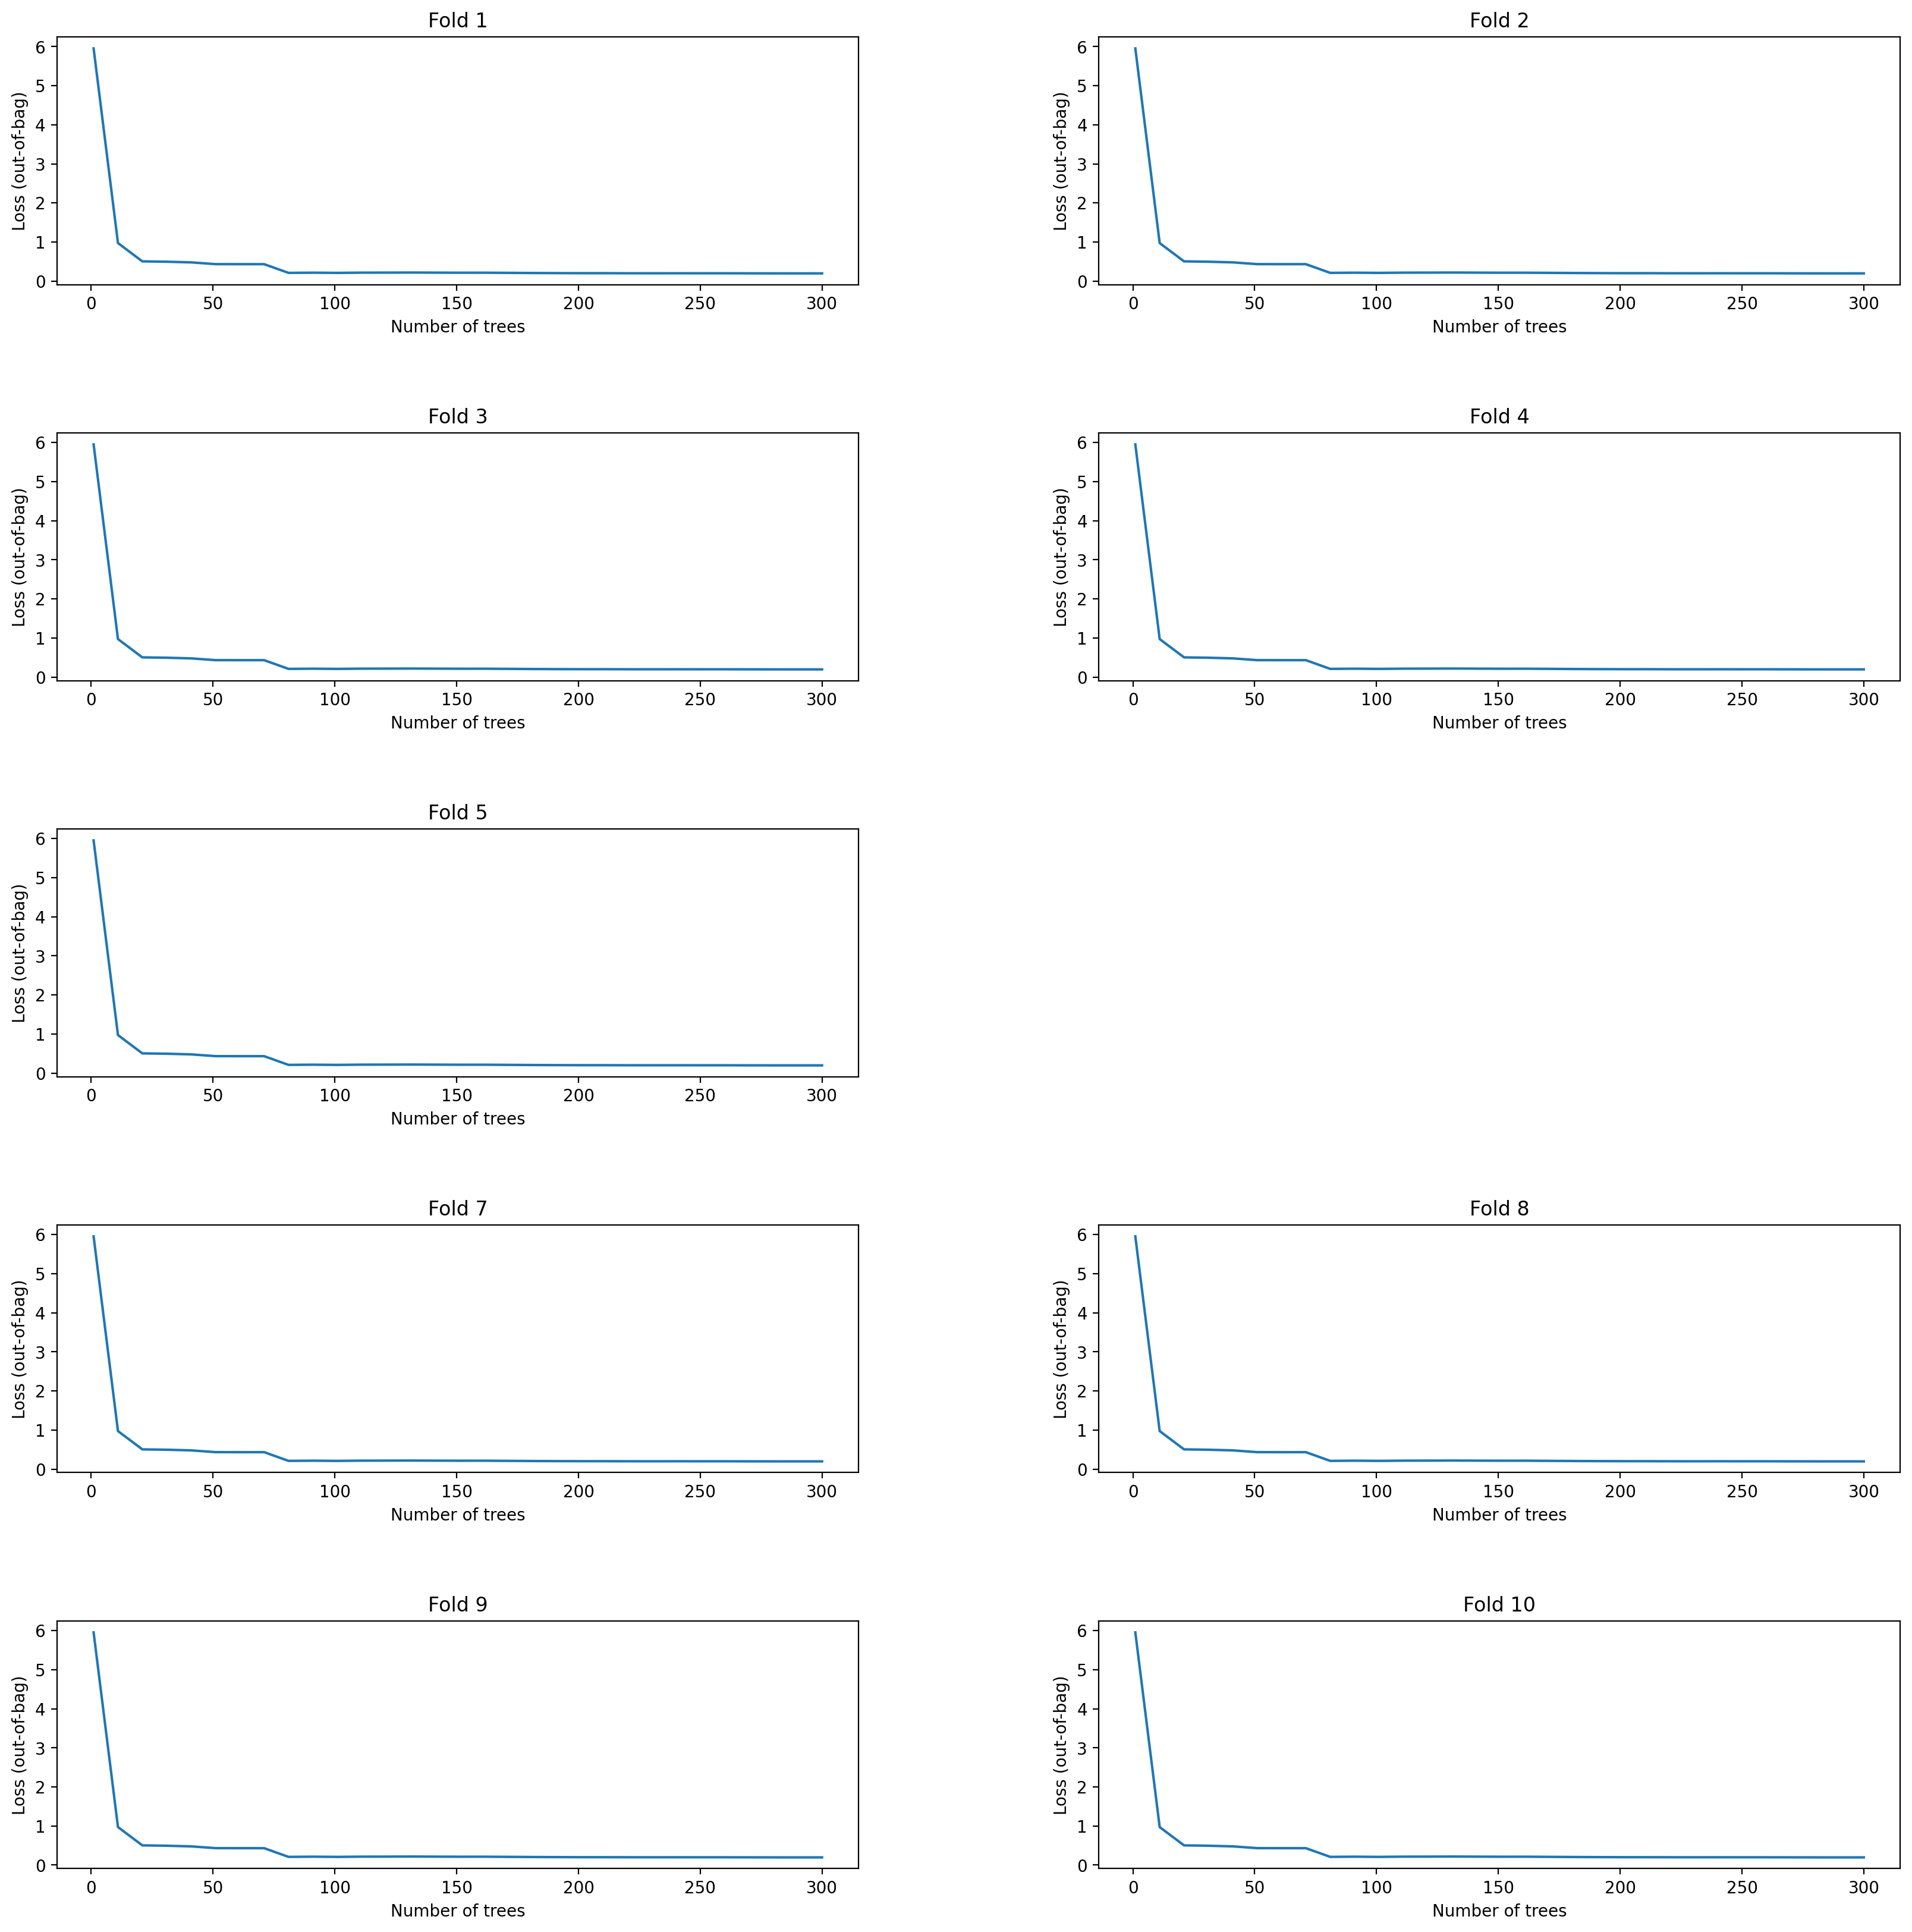

In [47]:
figure, axis = plt.subplots(5, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

### Step 8: Evaluation

---

In [48]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9184 loss: 0.1278
fold_2: acc: 0.9184 loss: 0.1278
fold_3: acc: 0.9184 loss: 0.1278
fold_4: acc: 0.9184 loss: 0.1278
fold_5: acc: 0.9184 loss: 0.1278
fold_6: acc: 0.9184 loss: 0.1278
fold_7: acc: 0.9184 loss: 0.1278
fold_8: acc: 0.9184 loss: 0.1278
fold_9: acc: 0.9184 loss: 0.1278
fold_10: acc: 0.9184 loss: 0.1278

Average accuracy: 1.8367  Average loss: 0.2556


In [49]:
# Variable importances (NO IDEA WHAT THIS MEANS WITH PCA...)

inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH


In [50]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("PCA_2" (1; #2), 139.0),
 ("PCA_6" (1; #6), 81.0),
 ("PCA_1" (1; #0), 52.0),
 ("PCA_3" (1; #3), 17.0),
 ("PCA_7" (1; #7), 5.0),
 ("PCA_4" (1; #4), 4.0),
 ("PCA_10" (1; #1), 1.0),
 ("PCA_8" (1; #8), 1.0)]

`Predictions`

In [51]:
# X_test_pca as pandas df to predict

column_names = [ 'PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6','PCA_7','PCA_8','PCA_9','PCA_10']


test_pd = pd.DataFrame(X_test_pca, columns=column_names)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_pd)


predictions = models['fold_1'].predict(test_ds)

n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]

print(n_predictions)

1/1 [==============================] - 0s 60ms/step
[[8.3e-07, 0.99999917], [0.7333335, 0.2666665], [1.0, 0.0], [0.96, 0.040000003], [0.99, 0.01], [0.72333351, 0.2766665], [0.02333415, 0.97666585], [1.0, 0.0], [0.93666666, 0.06333334], [0.59666696, 0.40333304], [0.03666747, 0.96333253], [0.91666668, 0.08333332], [0.87666672, 0.12333328], [0.88000005, 0.11999995], [0.85000007, 0.14999993], [1.0, 0.0], [1.0, 0.0], [0.98333333, 0.016666668], [0.98, 0.020000001], [0.98666667, 0.013333334], [0.99666667, 0.0033333334], [0.80000012, 0.19999988], [0.97333333, 0.02666667], [1.0, 0.0], [0.90333336, 0.09666664], [0.99333333, 0.006666667], [0.99, 0.01], [0.98, 0.020000001], [0.91000002, 0.08999998], [0.20333397, 0.796666], [0.03333414, 0.96666586], [0.92333334, 0.07666666], [0.87666672, 0.12333328], [0.99666667, 0.0033333334], [1.0, 0.0], [0.13666737, 0.8633326], [0.87666672, 0.12333328], [8.3e-07, 0.99999917], [0.95333333, 0.04666667], [0.96333333, 0.03666667], [0.47333372, 0.5266663], [0.9933333

2023-07-16 19:57:59.810620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [124]
	 [[{{node Placeholder/_0}}]]


### Conclusions

Random Trees classifier: 
- 92% average accuracy accross 10 folds. 
- Average loss: 0.32